In [1]:
import numpy as np
import matplotlib.pyplot as plt
from samana.output_storage import Output
import os
from trikde.triangleplot import TrianglePlot
from trikde.pdfs import estimate_parameter_ranges, InterpolatedLikelihood, IndependentLikelihoods, CustomPriorHyperCube
from scipy.interpolate import interp1d 
from matplotlib import colors

In [2]:
def bayes_factor_threshold(thresh, marginal_likelihood_interpolation):

    log10_mhm = 9.5
    while True:
        bayes_factor = int(1/marginal_likelihood_interpolation(log10_mhm))
        if bayes_factor <= thresh:
            return np.round(log10_mhm,1)
        else:
            log10_mhm -= 0.05
        if log10_mhm < 4.0:
            raise Exception('the posterior has no value with a Bayes factor of '+str(threshold)+':1')

def param_name_transformation(param_name):

    if param_name == 'log10_sigma_sub':
        name = r'$\log_{10} \Sigma_{\rm{sub}}/\rm{kpc^{-2}}$'
    elif param_name == 'log_mc':
        name = r'$\log_{10} m_{\rm{hm}} / {M_{\odot}}$'
    elif param_name == 'LOS_normalization':
        name = r'$\delta_{\rm{LOS}}$'
    elif param_name == 'shmf_log_slope':
        name = r'$\alpha$'
    return name
    
def label_axes_function():
    settings = {}
    settings['log10_sigma_sub'] = {}
    settings['log_mc'] = {}
    settings['LOS_normalization'] = {}
    settings['shmf_log_slope'] = {}
    settings['log10_sigma_sub']['tick_locations'] = [-2.2, -1.6, -1.0, -0.4, 0.2]
    settings['log10_sigma_sub']['tick_labels'] = settings['log10_sigma_sub']['tick_locations']
    settings['log_mc']['tick_locations'] = [4.0, 5.5, 7.0, 8.5, 10.0]
    settings['log_mc']['tick_labels'] = settings['log_mc']['tick_locations']
    settings['LOS_normalization']['tick_locations'] = [0.92,1.0,1.08]
    settings['LOS_normalization']['tick_labels'] = settings['LOS_normalization']['tick_locations']
    settings['shmf_log_slope']['tick_locations'] = [-1.93, -1.9, -1.82]
    settings['shmf_log_slope']['tick_labels'] = settings['shmf_log_slope']['tick_locations']
    return settings

## Load likelihoods

Load the final 2D posterior distributions

In [3]:
param_names = ['log10_sigma_sub', 'log_mc']
param_ranges = [[-2.2, 0.2], [4, 10]]

filename = './likelihoods_simple/fr_inference_no_priors.hdf5'
joint_fr = IndependentLikelihoods.from_hdf5(filename, param_names, param_ranges)

filename = './likelihoods_simple/joint_inference_no_priors.hdf5'
joint = IndependentLikelihoods.from_hdf5(filename, param_names, param_ranges)

file_out = './likelihoods_simple/joint_inference_galacticus_prior.hdf5'
joint_pdf_galacticus = IndependentLikelihoods.from_hdf5(filename, param_names, param_ranges)

file_out = './likelihoods_simple/joint_inference_nbody_prior.hdf5'
joint_pdf_nbody = IndependentLikelihoods.from_hdf5(filename, param_names, param_ranges)

file_out = './likelihoods_simple/joint_inference_CDM.hdf5'
joint_pdf_CDM = IndependentLikelihoods.from_hdf5(filename, param_names, param_ranges)

In [4]:
def sigma_sub_prior_function_nbody(samples):
    x = samples[:, 0]
    x0 = np.log10(0.05) # sigma_sub = 0.05, for example
    sigma = 0.3 # 0.3 dex uncertainty
    w = (x - x0)**2 / sigma ** 2
    return w

def sigma_sub_prior_function_galacticus(samples):
    x = samples[:, 0]
    x0 = np.log10(0.1) # sigma_sub = 0.05, for example
    sigma = 0.3 # 0.3 dex uncertainty
    w = (x - x0)**2 / sigma ** 2
    return w

def logmc_prior_function(samples):
    x = samples[:, 1]
    x0 = 4.0 # enforces CDM
    sigma = 0.5
    w = (x - x0)**2 / sigma ** 2
    return w
    
def load_priors(nbins):

    prior_probabilities = {}
    sigma_sub_prior = CustomPriorHyperCube(sigma_sub_prior_function_nbody, 
                                          param_names, 
                                          param_ranges,
                                          nbins)
    prior_probabilities['sigma_sub_prior_nbody'] = sigma_sub_prior
    
    sigma_sub_prior = CustomPriorHyperCube(sigma_sub_prior_function_galacticus, 
                                          param_names, 
                                          param_ranges,
                                          nbins)
    prior_probabilities['sigma_sub_prior_galacticus'] = sigma_sub_prior

    logmc_slope_prior = CustomPriorHyperCube(logmc_prior_function, 
                                              param_names, 
                                              param_ranges,
                                              nbins)
    prior_probabilities['logmc_prior'] = logmc_slope_prior

    return prior_probabilities
nbins = 25
priors = load_priors(nbins)

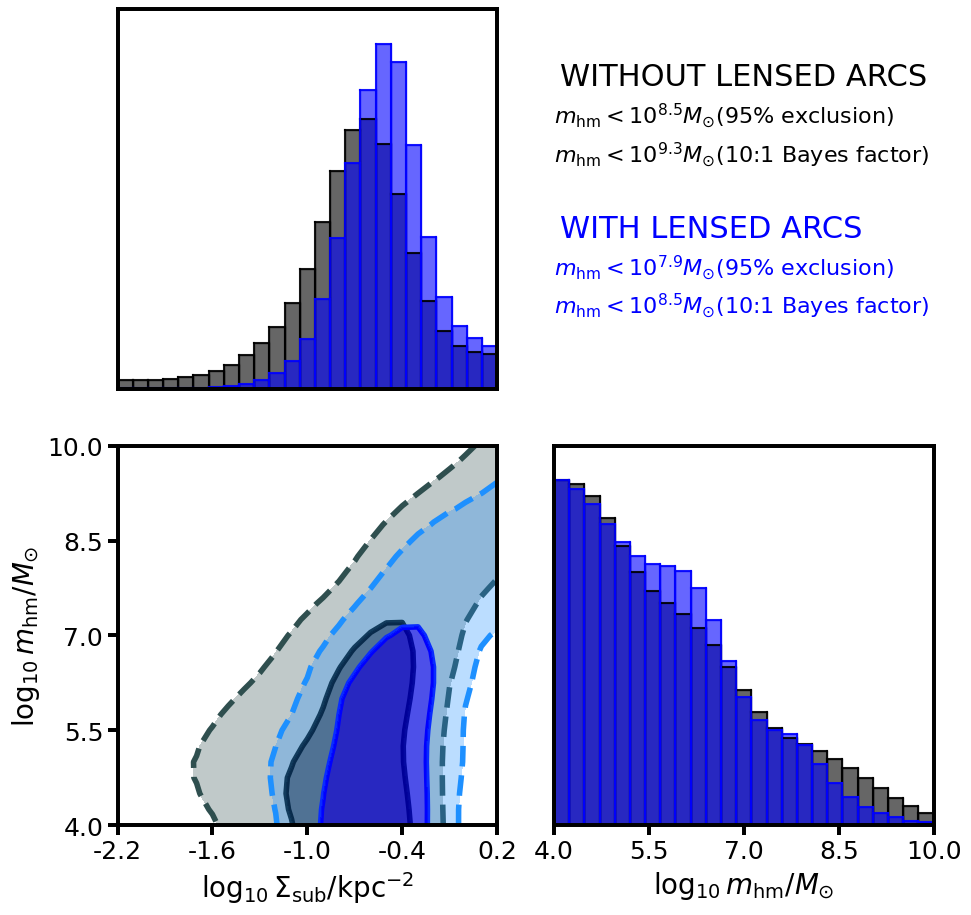

WITHOUT IMAGING DATA
95% exclusion:  8.457613815120444
10:1 Bayes factor:  9.2
Bayes factor at 10^9:  7
Bayes factor at 10^8.0:  4
Bayes factor at 10^7.5:  3


WITH IMAGING DATA
95% exclusion:  7.90642191944836
10:1 Bayes factor:  8.6
Bayes factor at 10^9:  21
Bayes factor at 10^8.0:  4
Bayes factor at 10^7.5:  3




In [5]:
triplot = TrianglePlot([
                        joint_fr,
                        joint
                        ],
                          param_name_transformation=param_name_transformation,
                      ticks_and_labels_settings=label_axes_function())
color_map = 'gist_heat'
triplot.cmap = color_map
axes = triplot.make_triplot(show_contours=False, filled_contours=True
                            , show_intervals=False,contour_levels=[0.05,0.32,1.0],
                            tick_label_font=18, axis_label_font=20
                           )
axes[1].annotate('WITHOUT LENSED ARCS', color='k', fontsize=22, xy=(0.015, 0.8), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{8.5} M_{\odot}$'+'(95% exclusion)', color='k', fontsize=16, 
                 xy=(0.00, 0.7), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{9.3} M_{\odot}$'+'(10:1 Bayes factor)', color='k', fontsize=16, 
                 xy=(0.00, 0.6), xycoords='axes fraction')
axes[1].annotate('WITH LENSED ARCS', color='b', fontsize=22, xy=(0.015, 0.4), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{7.9} M_{\odot}$'+'(95% exclusion)', color='b', fontsize=16, 
                 xy=(0.00, 0.3), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{8.5} M_{\odot}$'+'(10:1 Bayes factor)', color='b', fontsize=16, 
                 xy=(0.00, 0.2), xycoords='axes fraction')
#axes[4].plot(log10_sigma_sub, log10_mhm, color='w')
#plt.savefig('joint_inference_nopriors.pdf',bbox_inches='tight')
plt.show()


print('WITHOUT IMAGING DATA')
marginal = joint_fr.projection_1D('log_mc')
_bins = np.linspace(4.0, 10, len(marginal)+1)
bins = _bins[1:] - (_bins[1] - _bins[0])/2
interp_marginal = interp1d(bins, marginal / np.max(marginal))
cdf = np.cumsum(marginal)
cdf /= np.max(cdf)
cdf_inverse = interp1d(cdf, bins)
print('95% exclusion: ', cdf_inverse(0.95))
print('10:1 Bayes factor: ', bayes_factor_threshold(10, interp_marginal))
print('Bayes factor at 10^9: ', int(1/interp_marginal(9.0)))
print('Bayes factor at 10^8.0: ', int(1/interp_marginal(8.0)))
print('Bayes factor at 10^7.5: ', int(1/interp_marginal(7.5)))
print('\n')

print('WITH IMAGING DATA')
marginal = joint.projection_1D('log_mc')
_bins = np.linspace(4.0, 10, len(marginal)+1)
bins = _bins[1:] - (_bins[1] - _bins[0])/2
interp_marginal = interp1d(bins, marginal / np.max(marginal))
cdf = np.cumsum(marginal)
cdf /= np.max(cdf)
cdf_inverse = interp1d(cdf, bins)
print('95% exclusion: ', cdf_inverse(0.95))
print('10:1 Bayes factor: ', bayes_factor_threshold(10, interp_marginal))
print('Bayes factor at 10^9: ', int(1/interp_marginal(9.0)))
print('Bayes factor at 10^8.0: ', int(1/interp_marginal(8.0)))
print('Bayes factor at 10^7.5: ', int(1/interp_marginal(7.5)))
print('\n')

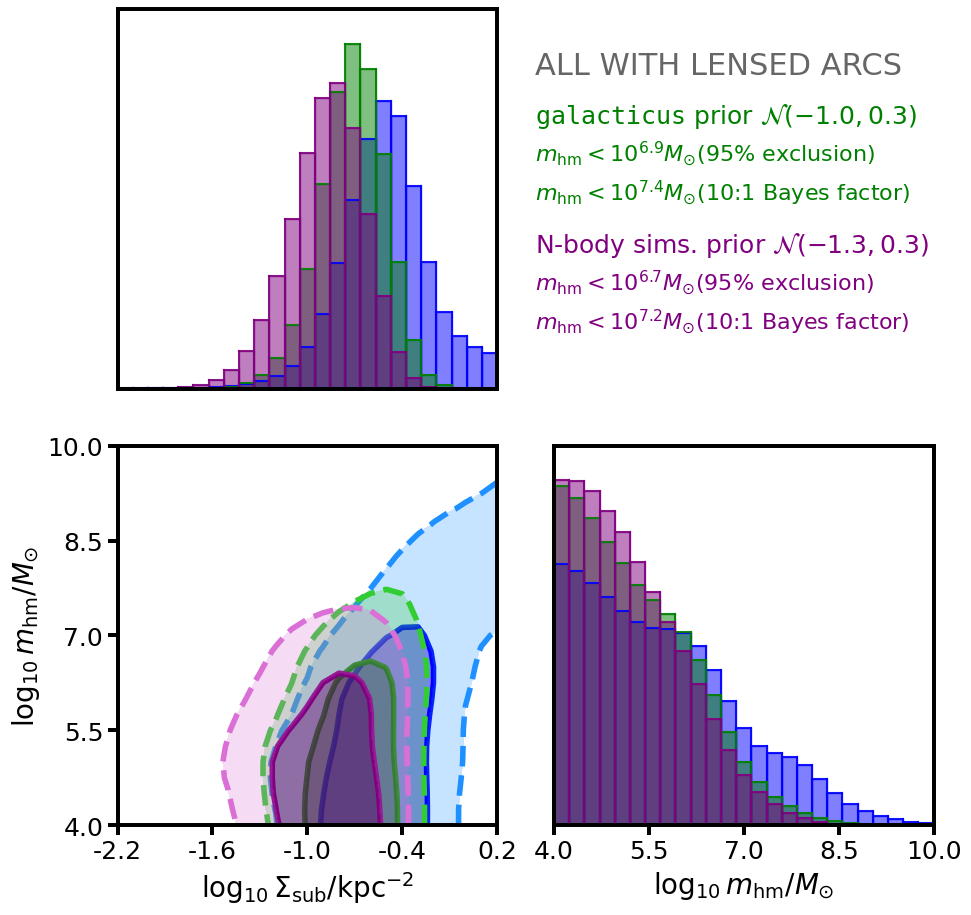

WITHOUT IMAGING DATA
galacticus prior: 
95% exclusion:  7.25552939217965
10:1 Bayes factor:  7.8
Bayes factor at 10^9:  80
Bayes factor at 10^8.0:  13
Bayes factor at 10^7.5:  7


n-body simulations prior: 
95% exclusion:  6.9804511566977006
10:1 Bayes factor:  7.5
Bayes factor at 10^9:  205
Bayes factor at 10^8.0:  24
Bayes factor at 10^7.5:  10


WITH IMAGING DATA
galacticus prior: 
95% exclusion:  6.881413242457523
10:1 Bayes factor:  7.4
Bayes factor at 10^9:  464
Bayes factor at 10^8.0:  30
Bayes factor at 10^7.5:  12


n-body simulations prior: 
95% exclusion:  6.7009390425275175
10:1 Bayes factor:  7.2
Bayes factor at 10^9:  1545
Bayes factor at 10^8.0:  55
Bayes factor at 10^7.5:  17




In [6]:
triplot = TrianglePlot([
                        joint,
                        joint * priors['sigma_sub_prior_galacticus'],
                        joint * priors['sigma_sub_prior_nbody']
                        ],
                          param_name_transformation=param_name_transformation,
                      ticks_and_labels_settings=label_axes_function())
contour_colors = [(colors.cnames['dodgerblue'], colors.cnames['blue'], 'k'), 
                 (colors.cnames['limegreen'], colors.cnames['green'], 'k'),
                  (colors.cnames['orchid'], colors.cnames['purple'], 'k')]
triplot._default_contour_colors = contour_colors

color_map = 'gist_heat'
triplot.cmap = color_map
axes = triplot.make_triplot(show_contours=False, filled_contours=True
                            , show_intervals=False,contour_levels=[0.05,0.32,1.0],
                            tick_label_font=18, axis_label_font=20, contour_alpha=0.5,
                           )

axes[1].annotate('ALL WITH LENSED ARCS', color='0.4', fontsize=22, xy=(-0.05, 0.83), xycoords='axes fraction')
axes[1].annotate(r'$\tt{galacticus}$'+' prior 'r'$\mathcal{N}\left(-1.0, 0.3\right)$', color='g', fontsize=18, xy=(-0.05, 0.7), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{6.9} M_{\odot}$'+'(95% exclusion)', color='g', fontsize=16, 
                 xy=(-0.05, 0.6), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{7.4} M_{\odot}$'+'(10:1 Bayes factor)', color='g', fontsize=16, 
                 xy=(-0.05, 0.5), xycoords='axes fraction')
axes[1].annotate('N-body sims. prior 'r'$\mathcal{N}\left(-1.3, 0.3\right)$', color='purple', fontsize=18, xy=(-0.05, 0.36), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{6.7} M_{\odot}$'+'(95% exclusion)', color='purple', fontsize=16, 
                 xy=(-0.05, 0.26), xycoords='axes fraction')
axes[1].annotate(r'$m_{\rm{hm}}< 10^{7.2} M_{\odot}$'+'(10:1 Bayes factor)', color='purple', fontsize=16, 
                 xy=(-0.05, 0.16), xycoords='axes fraction')
#plt.savefig('joint_inference_withpriors.pdf',bbox_inches='tight')
plt.show()

print('WITHOUT IMAGING DATA')
marginal = (joint_fr * priors['sigma_sub_prior_galacticus']).projection_1D('log_mc')
_bins = np.linspace(4.0, 10, len(marginal)+1)
bins = _bins[1:] - (_bins[1] - _bins[0])/2
interp_marginal = interp1d(bins, marginal / np.max(marginal))
cdf = np.cumsum(marginal)
cdf /= np.max(cdf)
cdf_inverse = interp1d(cdf, bins)
print('galacticus prior: ')
print('95% exclusion: ', cdf_inverse(0.95))
print('10:1 Bayes factor: ', bayes_factor_threshold(10, interp_marginal))
print('Bayes factor at 10^9: ', int(1/interp_marginal(9.0)))
print('Bayes factor at 10^8.0: ', int(1/interp_marginal(8.0)))
print('Bayes factor at 10^7.5: ', int(1/interp_marginal(7.5)))
print('\n')

marginal = (joint_fr * priors['sigma_sub_prior_nbody']).projection_1D('log_mc')
_bins = np.linspace(4.0, 10, len(marginal)+1)
bins = _bins[1:] - (_bins[1] - _bins[0])/2
interp_marginal = interp1d(bins, marginal / np.max(marginal))
cdf = np.cumsum(marginal)
cdf /= np.max(cdf)
cdf_inverse = interp1d(cdf, bins)
print('n-body simulations prior: ')
print('95% exclusion: ', cdf_inverse(0.95))
print('10:1 Bayes factor: ', bayes_factor_threshold(10, interp_marginal))
print('Bayes factor at 10^9: ', int(1/interp_marginal(9.0)))
print('Bayes factor at 10^8.0: ', int(1/interp_marginal(8.0)))
print('Bayes factor at 10^7.5: ', int(1/interp_marginal(7.5)))
print('\n')

print('WITH IMAGING DATA')
marginal = (joint * priors['sigma_sub_prior_galacticus']).projection_1D('log_mc')
_bins = np.linspace(4.0, 10, len(marginal)+1)
bins = _bins[1:] - (_bins[1] - _bins[0])/2
interp_marginal = interp1d(bins, marginal / np.max(marginal))
cdf = np.cumsum(marginal)
cdf /= np.max(cdf)
cdf_inverse = interp1d(cdf, bins)
print('galacticus prior: ')
print('95% exclusion: ', cdf_inverse(0.95))
print('10:1 Bayes factor: ', bayes_factor_threshold(10, interp_marginal))
print('Bayes factor at 10^9: ', int(1/interp_marginal(9.0)))
print('Bayes factor at 10^8.0: ', int(1/interp_marginal(8.0)))
print('Bayes factor at 10^7.5: ', int(1/interp_marginal(7.5)))
print('\n')

marginal = (joint * priors['sigma_sub_prior_nbody']).projection_1D('log_mc')
_bins = np.linspace(4.0, 10, len(marginal)+1)
bins = _bins[1:] - (_bins[1] - _bins[0])/2
interp_marginal = interp1d(bins, marginal / np.max(marginal))
cdf = np.cumsum(marginal)
cdf /= np.max(cdf)
cdf_inverse = interp1d(cdf, bins)
print('n-body simulations prior: ')
print('95% exclusion: ', cdf_inverse(0.95))
print('10:1 Bayes factor: ', bayes_factor_threshold(10, interp_marginal))
print('Bayes factor at 10^9: ', int(1/interp_marginal(9.0)))
print('Bayes factor at 10^8.0: ', int(1/interp_marginal(8.0)))
print('Bayes factor at 10^7.5: ', int(1/interp_marginal(7.5)))
print('\n')

parameter name:  log10_sigma_sub
68% confidence intervals: 
format: median (lower, upper) (param_min, param_max)

SAMPLES 1:
-0.7549548064346564 (-1.6972920079681417, -0.2864936606684698)
width:  1.410798347299672
SAMPLES 2:
-0.5906272431278543 (-1.124844929384337, -0.16750721874343366)
width:  0.9573377106409033


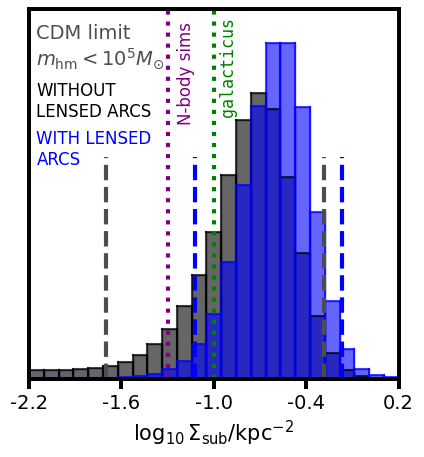

In [8]:
triplot = TrianglePlot([
                        joint_fr * priors['logmc_prior'],
                        joint * priors['logmc_prior']
                        ],
                          param_name_transformation=param_name_transformation,
                      ticks_and_labels_settings=label_axes_function())
axes = triplot.make_marginal('log10_sigma_sub', 
                            show_low=False, show_high=False)

(meds, uppers, lowers) = triplot.get_parameter_confidence_interval('log10_sigma_sub', 2, return_intervals=True)
lower_95, upper_95 = lowers[0], uppers[0]
lower_95_joint, upper_95_joint = lowers[1], uppers[1]
axes.axvline(lower_95, color='0.3', ymax=0.6, linestyle='--', lw=3)
axes.axvline(upper_95, color='0.3', ymax=0.6, linestyle='--', lw=3)

axes.axvline(lower_95_joint, color='b', ymax=0.6, linestyle='--', lw=3)
axes.axvline(upper_95_joint, color='b', ymax=0.6, linestyle='--', lw=3)

axes.axvline(-1.3, color='purple', ymax=1.0, linestyle=':', lw=3)
axes.annotate('N-body sims', xy=(0.4, 0.7), xycoords='axes fraction', fontsize=12, rotation=90, color='purple')
axes.axvline(np.log10(0.1), color='green', ymax=1., linestyle=':', lw=3)
axes.annotate(r'$\tt{galacticus}$', xy=(0.51, 0.72), xycoords='axes fraction', fontsize=12, rotation=90, color='green')
axes.annotate('CDM limit\n'+r'$m_{\rm{hm}} <  10^5 M_{\odot}$', xy=(0.02, 0.85), xycoords='axes fraction', 
              color='0.3', fontsize=14)
axes.annotate('WITHOUT\nLENSED ARCS', xy=(0.02, 0.71),  xycoords='axes fraction', 
              color='k', fontsize=12)
axes.annotate('WITH LENSED\nARCS', xy=(0.02, 0.58),  xycoords='axes fraction', 
              color='b', fontsize=12)
#plt.savefig('CDM_inference.pdf',bbox_inches='tight')
plt.show()
